Randomised Riemannian Hamiltonian Monte Carlo for Sampling on $S^{5} \subset \mathbb{R}^{6}$

Defined by $g(x) = \sum^{6}_{i=1}x^{2}_{i} - 1 = 0$, we have $\mathcal{M} := \{x \in \mathbb{R}^{6} \mid g(x) = 0\}$

$T_{p}\mathcal{M} =  \{v \mid \langle \nabla g(p),v \rangle = 0 \}$

$G(q) = g'(q) = (2x_{i})^{6}_{i=1}$

$\pi = I - G^T (G G^T)^{-1} G = I - G^T G/4$ is the projection onto the tangent space.

1) Dynamics

Simulating Hamiltonian Dynamics with potential governed by
$U(q) = -\log{\pi_{\mathcal{H}}(q)}$, where $\pi_{\mathcal{H}}$ is the density function of the Bingham-von Mises-Fisher distribution. To compare 3 different sampling methods.

The Bingham-von Mises-Fisher distribution on the Sphere is determined by

$\pi_{\mathcal{H}}(x) \propto \exp{\{ c^{T}x + x^{T}Ax\}}$
in $\mathbb{R}^{3}$, $c \propto \mu$



We have $\nabla_{q} V(q) = -\nabla_{q}\log{\pi_{\mathcal{H}}(q)} = -\nabla_{q}(c^{T}q+q^{T}Aq) = -c^{T} - 2Aq$

In [12]:
import numba
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time



## Uncomment for Multimodal distributions.
# #Bi Modal
# c1 = 40.
# mean = np.array([c1,0.,0.,0.,0.])
# A = np.diag(np.array([-20.,-10.,0.,10.,20.]))
# dimension  = 5

#k = 4
c1 = 100.
mean = np.array([c1,0.,0.])
A = np.diag(np.array([-1000.,0.,1000.]))
dimension = 3



'Numba functions'

@numba.jit(nopython=True)
def matrix_vec_multiplication(A,x):
    v = np.zeros(len(A))
    
    for i in range(len(A)):
        for j in range(len(x)):
                v[i] += A[i][j] * x[j]
    return v

@numba.jit(nopython=True)
def dot_product(v1,v2):
    dot = 0
    for i in range(len(v1)):
        
        dot += v1[i]*v2[i]
        
    return dot

@numba.jit(nopython=True)
def g(q):
    #.sum
    y = np.sum(np.power(q,2)) - 1
    return y


@numba.jit(nopython=True)
def G(q):
    z = 2*q
    return z

#need to do this onwards
@numba.jit(nopython=True)
def potential_derv(q):
    v = matrix_vec_multiplication(A,q)
    mu = - mean - 2*v
    return mu
        

In [13]:
@numba.jit(nopython=True)
def tangent_space_gaussian(q):
    
    v = np.random.normal(0.,1.0,dimension).T
    
    G_q = G(q)
    
    gram_inv = 1/dot_product(G_q,G_q)
    
    proj_matrix = np.eye(dimension) - gram_inv*np.outer(G_q,G_q)
    
    #sample 3d gaussian and then project onto tangent space.
    v = matrix_vec_multiplication(proj_matrix,v)
    
    return v

In [14]:
#RATTLE Hamiltonian Flow
@numba.jit(nopython=True)
def Geodesic(x0,v0,n,dt):
    vn = v0
    qn = x0
    vhalf = v0
    G_q = G(qn)
    for i in range(n):
        #solver for Lagrange position multipliers
        Q = qn + vn*dt
        for j in range(50):
            g_Q = g(Q)
            dlambda = g_Q/dot_product(G(Q),G_q)
            Q = Q - G_q*dlambda
            if abs(g_Q) < 1e-8:
                break
        
        #half step
        vhalf = (Q-qn)/dt
        qn = Q
    
        G_q = G(qn)
        gram_inv = 1/dot_product(G_q,G_q)
        
        #linear solver Lagrange velocity multipliers
        b = np.dot(G_q,2*vhalf/dt)
        coeffs_v = gram_inv*b
        
        #full step
        vn = vhalf - 0.5*dt*G(qn)*coeffs_v

        
            
    return qn,vn





#RATTLE Hamiltonian Flow
@numba.jit(nopython=True)
def g_BAOAB(γ,x0,v0,Kr,Kp,dt):
    
    pn = v0
    qn = x0
    
    G_q = G(qn)
    gram_inv = 1/dot_product(G_q,G_q)
    pderv = potential_derv(qn)
    
    a = np.exp(-γ*dt) 
    
    b = np.sqrt(1-a**2)
    
    
    for i in range(Kp):
        
        
        #B
        μ = (dt/2)*np.dot(G_q,pderv)*gram_inv
        
        pn = pn - dt*pderv/2 + μ*G_q
        
        #A
        [qn,pn] = Geodesic(qn,pn,Kr,dt/(2*Kr))
        
        
        #O
        G_q = G(qn)
        gram_inv = 1/dot_product(G_q,G_q)
        
        gaussian = tangent_space_gaussian(qn)
        
        μ = -b*np.dot(G_q,gaussian)*gram_inv
        
        pn = a*pn + b*gaussian + μ*G_q
        
        
        #A
        [qn,pn] = Geodesic(qn,pn,Kr,dt/(2*Kr))
        
        
        #B
        G_q = G(qn)
        gram_inv = 1/dot_product(G_q,G_q)
        
        pderv = potential_derv(qn)
        μ = (dt/2)*np.dot(G_q,pderv)*gram_inv
        
        pn = pn - dt*pderv/2 + μ*G_q
            
    return qn,pn

# g-BAOAB Monte Carlo

In [15]:
@numba.jit(nopython=True)
def g_BAOAB_MC(γ,Kr,num_of_events,dt,x_init):
   
    
    #Exponential Expected Value
    x = x_init
    v = tangent_space_gaussian(x)
    position_list = [x_init]
    
    
    for i in range(num_of_events):
        x,v = g_BAOAB(γ,x,v,Kr,1,dt)
        
        position_list.append(x)
        
        if i%10000==0:
            print(i)
    return position_list

2) Event Time Sampling


# Bias at different step sizes.

In [16]:
num_of_events = 10000
λ = 0.1
@numba.jit(nopython=True)
def f(q):
    return -dot_product(mean,q) - dot_product(q,matrix_vec_multiplication(A,q))

# RMHMC

In [17]:
#RATTLE Hamiltonian Flow
@numba.jit(nopython=True)
def RATTLE_with_Potential(x0,v0,t,dt):
    n = np.floor(t/dt)
    vn = v0
    qn = x0
    vhalf = v0
    G_q = G(qn)
    pderv = potential_derv(qn)
    for i in range(int(n)):
        
        
        
        #solver for Lagrange position multipliers
        Q = qn + vn*dt - 0.5*dt*dt*pderv
        for j in range(50):
            g_Q = g(Q)
            dlambda = g_Q/dot_product(G(Q),G_q)
            Q = Q - G_q*dlambda
            if abs(g_Q) < 1e-8:
                break
        
        #half step
        vhalf = (Q-qn)/dt
        qn = Q
    
        
        pderv =  potential_derv(qn)
        G_q = G(qn)
        gram_inv = 1/dot_product(G_q,G_q)
        
        #linear solver Lagrange velocity multipliers
        b = np.dot(G_q,2*vhalf/dt - pderv)
        coeffs_v = gram_inv*b
        
        #full step
        vn = vhalf - 0.5*dt*pderv - 0.5*dt*G(qn)*coeffs_v

        
            
    return qn,vn

In [18]:
#Sampling Event Times
@numba.jit(nopython=True)
def time_exp(lam):
    t = np.random.exponential(lam)
    return t

In [19]:
@numba.jit(nopython=True)
def hamiltonian(x,v):
    h = -(dot_product(mean,x) + dot_product(x,matrix_vec_multiplication(A,x)))+ 0.5*np.linalg.norm(v)**2
    return h

In [20]:
@numba.jit(nopython=True)
def RRHMC(num_of_events,dt_max,T,x_init,MH=True):
    
    #Exponential Expected Value
    rate = T
    x = x_init
    
    position_list = [x_init]
    v = tangent_space_gaussian(x)
    
    accept = 0.
    gradient_evaluations = 0
    
    for i in range(num_of_events):
        
        t = time_exp(rate)
        L = np.ceil(t/dt_max)
        
        gradient_evaluations += L
        dt = t/L
        
        h = hamiltonian(x,v) 
        
        xnew,vnew = RATTLE_with_Potential(x,v,t,dt)
        
        h_new = hamiltonian(xnew,vnew) 
        
        if MH:
            #metropolis hasting step
            u = np.random.rand()
            α = np.exp(-h_new+h)
            accept += min(1,α)
            if u <= α:
                x = xnew
        else:
            x = xnew
        
        position_list.append(x)
        
        #resampling velocity
        v = tangent_space_gaussian(x)
        if i%10000 == 0:
            print(i)
    
    
    accept/=num_of_events
    gradient_evaluations /= num_of_events
    
    return position_list,accept,gradient_evaluations


In [21]:
@numba.jit(nopython=True)
def RHMC(num_of_events,dt,T,x_init,MH=True):
    
    #Exponential Expected Value
    x = x_init
    
    position_list = [x_init]
    v = tangent_space_gaussian(x)
    
    accept = 0.
    
    for i in range(num_of_events):
        
        h = hamiltonian(x,v) 
        
        xnew,vnew = RATTLE_with_Potential(x,v,T,dt)
        
        
        h_new = hamiltonian(xnew,vnew) 
        
        if MH:
            #metropolis hasting step
            u = np.random.rand()
            α = np.exp(-h_new+h)
            accept += min(1,α)
            if u <= α:
                x = xnew
        
        else:
            x = xnew
            
            
        position_list.append(x)
        #resampling velocity
        v = tangent_space_gaussian(x)
        if i%10000 == 0:
            print(i)
    
    accept/=num_of_events
    
    return position_list,accept


## ESS per Gradient Evaluation

In [22]:
import statsmodels.api as sm
#ESS per gradient evaluation
x_init = np.array([0.,0.,1.])
N_samples = 100000

dt_list = np.linspace(0.00001,0.03,100)
print(dt_list)

Gradient_p_ESS_DT_1 = []
Gradient_p_ESS_RT_1 = []

Gradient_p_ESS_DT_2 = []
Gradient_p_ESS_RT_2 = []

Gradient_p_ESS_DT_5 = []
Gradient_p_ESS_RT_5 = []

Gradient_p_ESS_DT_10 = []
Gradient_p_ESS_RT_10 = []

Gradient_p_ESS_g_BAOAB_2 = []
Gradient_p_ESS_g_BAOAB_0_5 = []
Gradient_p_ESS_g_BAOAB_10 = []


accept_RT_list_1 = []
accept_DT_list_1 = []

accept_RT_list_2 = []
accept_DT_list_2 = []

accept_RT_list_5 = []
accept_DT_list_5 = []

accept_RT_list_10 = []
accept_DT_list_10 = []

for dt_ in dt_list:
    
    T = 5*dt_
    
    N_1 = 10.
    N_2 = 50.
    N_3 = 200.
    
    DT_samples_5,accept_DT_5 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_5,accept_RT_5, gradient_evaluations_5 = RRHMC(N_samples,dt_,T,x_init)
    
    g_BAOAB_samples_2 = g_BAOAB_MC(N_2,1,N_samples,dt_,x_init)
    g_BAOAB_samples_0_5 = g_BAOAB_MC(N_1,1,N_samples,dt_,x_init)
    g_BAOAB_samples_10 = g_BAOAB_MC(N_3,1,N_samples,dt_,x_init)
    
    #storing acceptance rates
    accept_RT_list_5.append(accept_RT_5)
    accept_DT_list_5.append(accept_DT_5)
    
    
    T = 1*dt_
    
    DT_samples_1,accept_DT_1 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_1,accept_RT_1, gradient_evaluations_1 = RRHMC(N_samples,dt_,T,x_init)
    
    
    #storing acceptance rates
    accept_RT_list_1.append(accept_RT_1)
    accept_DT_list_1.append(accept_DT_1)
    
    T = 2*dt_
    
    DT_samples_2,accept_DT_2 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_2,accept_RT_2, gradient_evaluations_2 = RRHMC(N_samples,dt_,T,x_init)
    
    #storing acceptance rates
    accept_RT_list_2.append(accept_RT_2)
    accept_DT_list_2.append(accept_DT_2)
    
    
    
    T = 10*dt_
    
    DT_samples_10,accept_DT_10 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_10,accept_RT_10, gradient_evaluations_10 = RRHMC(N_samples,dt_,T,x_init)
    
    
    #storing acceptance rates
    accept_RT_list_10.append(accept_RT_10)
    accept_DT_list_10.append(accept_DT_10)
    #####################################################################
    #Gradient Evaluations per ESS - DT - 1
    front = len(DT_samples_1)//10
    
    N = len(DT_samples_1)- front

    auto_corr_vector_DT_1 = []
    
    for i in DT_samples_1:
        
        auto_corr_vector_DT_1.append(f(i))
    
    auto_DT_1 = sm.tsa.acf(auto_corr_vector_DT_1[front:],nlags = N//50)
    
    IAC_DT_1 = np.sum(auto_DT_1)
    
    print('IAC_DT=',2*IAC_DT_1-1)
    
    ESS_percent_DT_1 = 1/(2*IAC_DT_1 - 1)
    
    Gradient_p_ESS_DT_1.append(1./ESS_percent_DT_1)
    
    #Gradient Evaluations per ESS - RT - 1
    front = len(RT_samples_1)//10
    
    N = len(RT_samples_1)- front

    auto_corr_vector_RT_1 = []
    
    for i in RT_samples_1:
        
        auto_corr_vector_RT_1.append(f(i))
    
    auto_RT_1 = sm.tsa.acf(auto_corr_vector_RT_1[front:],nlags = N//50)
    
    IAC_RT_1 = np.sum(auto_RT_1)
    
    print('IAC_RT=',2*IAC_RT_1-1)
    
    ESS_percent_RT_1 = 1/(2*IAC_RT_1 - 1)
    
    Gradient_p_ESS_RT_1.append(gradient_evaluations_1/ESS_percent_RT_1)
    
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 2
    front = len(DT_samples_2)//10
    
    N = len(DT_samples_2)- front

    auto_corr_vector_DT_2 = []
    
    for i in DT_samples_2:
        
        auto_corr_vector_DT_2.append(f(i))
    
    auto_DT_2 = sm.tsa.acf(auto_corr_vector_DT_2[front:],nlags = N//50)
    
    IAC_DT_2 = np.sum(auto_DT_2)
    
    print('IAC_DT=',2*IAC_DT_2-1)
    
    ESS_percent_DT_2 = 1/(2*IAC_DT_2 - 1)
    
    Gradient_p_ESS_DT_2.append(2./ESS_percent_DT_2)
    
    #Gradient Evaluations per ESS - RT - 2
    front = len(RT_samples_2)//10
    
    N = len(RT_samples_2)- front

    auto_corr_vector_RT_2 = []
    
    for i in RT_samples_2:
        
        auto_corr_vector_RT_2.append(f(i))
    
    auto_RT_2 = sm.tsa.acf(auto_corr_vector_RT_2[front:],nlags = N//50)
    
    IAC_RT_2 = np.sum(auto_RT_2)
    
    print('IAC_RT=',2*IAC_RT_2-1)
    
    ESS_percent_RT_2 = 1/(2*IAC_RT_2 - 1)
    
    Gradient_p_ESS_RT_2.append(gradient_evaluations_2/ESS_percent_RT_2)
    
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 5
    front = len(DT_samples_5)//10
    
    N = len(DT_samples_5)- front

    auto_corr_vector_DT_5 = []
    
    for i in DT_samples_5:
        
        auto_corr_vector_DT_5.append(f(i))
    
    auto_DT_5 = sm.tsa.acf(auto_corr_vector_DT_5[front:],nlags = N//50)
    
    IAC_DT_5 = np.sum(auto_DT_5)
    
    print('IAC_DT=',2*IAC_DT_5-1)
    
    ESS_percent_DT_5 = 1/(2*IAC_DT_5 - 1)
    
    Gradient_p_ESS_DT_5.append(5./ESS_percent_DT_5)
    
    #Gradient Evaluations per ESS - RT - 5
    front = len(RT_samples_5)//10
    
    N = len(RT_samples_5)- front

    auto_corr_vector_RT_5 = []
    
    for i in RT_samples_5:
        
        auto_corr_vector_RT_5.append(f(i))
    
    auto_RT_5 = sm.tsa.acf(auto_corr_vector_RT_5[front:],nlags = N//50)
    
    IAC_RT_5 = np.sum(auto_RT_5)
    
    print('IAC_RT=',2*IAC_RT_5-1)
    
    ESS_percent_RT_5 = 1/(2*IAC_RT_5 - 1)
    
    Gradient_p_ESS_RT_5.append(gradient_evaluations_5/ESS_percent_RT_5)
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 10
    front = len(DT_samples_10)//10
    
    N = len(DT_samples_10)- front

    auto_corr_vector_DT_10 = []
    
    for i in DT_samples_10:
        
        auto_corr_vector_DT_10.append(f(i))
    
    auto_DT_10 = sm.tsa.acf(auto_corr_vector_DT_10[front:],nlags = N//50)
    
    IAC_DT_10 = np.sum(auto_DT_10)
    
    print('IAC_DT=',2*IAC_DT_10-1)
    
    ESS_percent_DT_10 = 1/(2*IAC_DT_10 - 1)
    
    Gradient_p_ESS_DT_10.append(10./ESS_percent_DT_10)
    
    #Gradient Evaluations per ESS - RT - 10
    front = len(RT_samples_10)//10
    
    N = len(RT_samples_10)- front

    auto_corr_vector_RT_10 = []
    
    for i in RT_samples_10:
        
        auto_corr_vector_RT_10.append(f(i))
    
    auto_RT_10 = sm.tsa.acf(auto_corr_vector_RT_10[front:],nlags = N//50)
    
    IAC_RT_10 = np.sum(auto_RT_10)
    
    print('IAC_RT=',2*IAC_RT_10-1)
    
    ESS_percent_RT_10 = 1/(2*IAC_RT_10 - 1)
    
    Gradient_p_ESS_RT_10.append(gradient_evaluations_10/ESS_percent_RT_10)
    
    
    
    ###################################################################
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 2
    front = len(g_BAOAB_samples_2)//10
    
    N = len(g_BAOAB_samples_2)- front

    auto_corr_vector_g_BAOAB_2 = []
    
    for i in g_BAOAB_samples_2:
        
        auto_corr_vector_g_BAOAB_2.append(f(i))
    
    auto_g_BAOAB_2 = sm.tsa.acf(auto_corr_vector_g_BAOAB_2[front:],nlags = N//50)
    
    IAC_g_BAOAB_2 = np.sum(auto_g_BAOAB_2)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_2-1)
    
    ESS_percent_g_BAOAB_2 = 1/(2*IAC_g_BAOAB_2 - 1)
    
    Gradient_p_ESS_g_BAOAB_2.append(1/ESS_percent_g_BAOAB_2)
    
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 0.5
    front = len(g_BAOAB_samples_0_5)//10
    
    N = len(g_BAOAB_samples_0_5)- front

    auto_corr_vector_g_BAOAB_0_5 = []
    
    for i in g_BAOAB_samples_0_5:
        
        auto_corr_vector_g_BAOAB_0_5.append(f(i))
    
    auto_g_BAOAB_0_5 = sm.tsa.acf(auto_corr_vector_g_BAOAB_0_5[front:],nlags = N//50)
    
    IAC_g_BAOAB_0_5 = np.sum(auto_g_BAOAB_0_5)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_0_5-1)
    
    ESS_percent_g_BAOAB_0_5 = 1/(2*IAC_g_BAOAB_0_5 - 1)
    
    Gradient_p_ESS_g_BAOAB_0_5.append(1/ESS_percent_g_BAOAB_0_5)
    
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 10.0
    front = len(g_BAOAB_samples_10)//10
    
    N = len(g_BAOAB_samples_10)- front

    auto_corr_vector_g_BAOAB_10 = []
    
    for i in g_BAOAB_samples_10:
        
        auto_corr_vector_g_BAOAB_10.append(f(i))
    
    auto_g_BAOAB_10 = sm.tsa.acf(auto_corr_vector_g_BAOAB_10[front:],nlags = N//50)
    
    IAC_g_BAOAB_10 = np.sum(auto_g_BAOAB_10)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_10-1)
    
    ESS_percent_g_BAOAB_10 = 1/(2*IAC_g_BAOAB_10 - 1)
    
    Gradient_p_ESS_g_BAOAB_10.append(1/ESS_percent_g_BAOAB_10)


    

[1.00000000e-05 3.12929293e-04 6.15858586e-04 9.18787879e-04
 1.22171717e-03 1.52464646e-03 1.82757576e-03 2.13050505e-03
 2.43343434e-03 2.73636364e-03 3.03929293e-03 3.34222222e-03
 3.64515152e-03 3.94808081e-03 4.25101010e-03 4.55393939e-03
 4.85686869e-03 5.15979798e-03 5.46272727e-03 5.76565657e-03
 6.06858586e-03 6.37151515e-03 6.67444444e-03 6.97737374e-03
 7.28030303e-03 7.58323232e-03 7.88616162e-03 8.18909091e-03
 8.49202020e-03 8.79494949e-03 9.09787879e-03 9.40080808e-03
 9.70373737e-03 1.00066667e-02 1.03095960e-02 1.06125253e-02
 1.09154545e-02 1.12183838e-02 1.15213131e-02 1.18242424e-02
 1.21271717e-02 1.24301010e-02 1.27330303e-02 1.30359596e-02
 1.33388889e-02 1.36418182e-02 1.39447475e-02 1.42476768e-02
 1.45506061e-02 1.48535354e-02 1.51564646e-02 1.54593939e-02
 1.57623232e-02 1.60652525e-02 1.63681818e-02 1.66711111e-02
 1.69740404e-02 1.72769697e-02 1.75798990e-02 1.78828283e-02
 1.81857576e-02 1.84886869e-02 1.87916162e-02 1.90945455e-02
 1.93974747e-02 1.970040

40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 124.48443707121602
IAC_RT= 74.59562353501013
IAC_DT= 49.47099423506801
IAC_RT= 26.711389041956696
IAC_DT= 4.9405349105742715
IAC_RT= 11.3405454370985
IAC_DT= 1.4544475834073136
IAC_RT= 4.35032450391848
IAC_g_BAOAB= 22.55978352157625
IAC_g_BAOAB= 42.41144184884166
IAC_g_BAOAB= 45.015815020541694
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000


20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 20.507184469182885
IAC_RT= 14.926850351521397
IAC_DT= 7.420300950054724
IAC_RT= 8.401689287192324
IAC_DT= 0.6186800009603557
IAC_RT= 4.0093483989729055
IAC_DT= 182.97567978300458
IAC_RT= 4.480126964253932
IAC_g_BAOAB= 5.823346039180185
IAC_g_BAOAB= 16.83790250974524
IAC_g_BAOAB= 19.67380442127645
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
5000

70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 13.879216665684279
IAC_RT= 8.101536538449704
IAC_DT= 3.536270525715964
IAC_RT= 4.756478351817128
IAC_DT= 1.5457600091448938
IAC_RT= 4.310639225175884
IAC_DT= 8.226028142236355
IAC_RT= 1.8228131615846106
IAC_g_BAOAB= 5.767560361934405
IAC_g_BAOAB= 14.632331960875874
IAC_g_BAOAB= 10.400648326438418
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10

20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 8.128290089152909
IAC_RT= 4.372507383411187
IAC_DT= 1.2502226739881577
IAC_RT= 2.9122514427877095
IAC_DT= 17.330318703793445
IAC_RT= 2.6227366585256617
IAC_DT= 9.138064759380564
IAC_RT= 2.3736321745307767
IAC_g_BAOAB= 3.597746263986126
IAC_g_BAOAB= 7.968686874593393
IAC_g_BAOAB= 6.066846443242814
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
5000

10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 4.209883468211962
IAC_RT= 5.335380380896213
IAC_DT= 2.1087651433795944
IAC_RT= 2.7851047567955547
IAC_DT= 25.560899420684024
IAC_RT= 2.451107284798637
IAC_DT= 8.306935445947488
IAC_RT= 2.2272118263452803
IAC_g_BAOAB= 2.4159904640640293
IAC_g_BAOAB= 9.367618339202298
IAC_g_BAOAB= 6.580778944799954
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
4000

10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 4.621733711873403
IAC_RT= 1.9418196733943804
IAC_DT= 1.5158504775981267
IAC_RT= 5.057693294419548
IAC_DT= 5.170251803127316
IAC_RT= 2.2092401027876285
IAC_DT= 1.5163392609113795
IAC_RT= 5.32476746977919
IAC_g_BAOAB= 2.508829868720652
IAC_g_BAOAB= 4.932948121821604
IAC_g_BAOAB= 4.553815086365088
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000


IAC_g_BAOAB= 2.5856747303082184
IAC_g_BAOAB= 3.2839424311648804
IAC_g_BAOAB= 2.0482873915930893
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 1.5114691413326242
IAC_RT= 2.2245961157954746
IAC_DT= 1.8829330726513005
IAC_RT= 4.794264545382359
IAC_DT= 402.8278888193129
IAC_RT= 1.9879136369304402
IAC_DT= 70.55253716825426
IAC_RT= 3.270764787735504
IAC_g_BAOAB= 1.5348112082414862
IAC_g_BAOAB= 7.235798785509665
IAC_g_BAOAB= 

IAC_RT= 2.6653589084939275
IAC_DT= 12.909033145557903
IAC_RT= 2.4842055412034947
IAC_g_BAOAB= 2.5005527590058003
IAC_g_BAOAB= 6.09200033597177
IAC_g_BAOAB= 2.261992677343241
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 1.9390501343787516
IAC_RT= 4.448421634457251
IAC_DT= 17.35597802276771
IAC_RT= 4.225389713361592
IAC_DT= 2.844898685237988
IAC_RT= 3.763929347349184
IAC_DT= 9.244704268641096
IAC_RT= 3.308712527906387
I

IAC_DT= 1.8820072081668968
IAC_RT= 2.2713814136782005
IAC_DT= 1.2383445636126509
IAC_RT= 2.4835409103318398
IAC_g_BAOAB= 1.1486428407851283
IAC_g_BAOAB= 3.3551890352299214
IAC_g_BAOAB= 0.8089917261377502
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 1.2916570429420235
IAC_RT= 4.671708910898966
IAC_DT= 5.084963381959129
IAC_RT= 2.906125148271979
IAC_DT= 3.036915411658228
IAC_RT= 2.7168955033577857
IAC_DT= 1.580605573376

IAC_DT= 2.4060930597791206
IAC_RT= 4.735335513394649
IAC_DT= 282.87511940848435
IAC_RT= 3.8787855557773208
IAC_DT= 718.7091378163152
IAC_RT= 2.5367686703530605
IAC_g_BAOAB= 1.4505668806041965
IAC_g_BAOAB= 3.666563167837392
IAC_g_BAOAB= 1.184294718207624
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 1.95621979656952
IAC_RT= 4.318292552305979
IAC_DT= 4.6979564132454055
IAC_RT= 3.890954741566503
IAC_DT= 82.2404812436455
I

70000
80000
90000
IAC_DT= 4.367846560901964
IAC_RT= 2.809870101082567
IAC_DT= 11.859651327679368
IAC_RT= 2.0862150384714333
IAC_DT= 4.787203010369083
IAC_RT= 3.7283170117326447
IAC_DT= 3.709719574724579
IAC_RT= 3.4610765738034015
IAC_g_BAOAB= 1.3407672364023226
IAC_g_BAOAB= 2.0738812825599693
IAC_g_BAOAB= 1.3806712539943478
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
IAC_DT= 4.4014831120821505
IAC_RT= 5.469694471589753
IAC_D

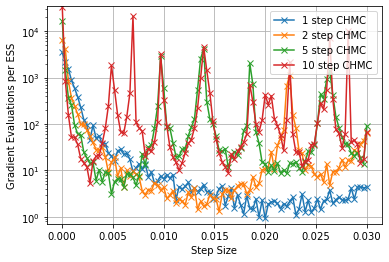

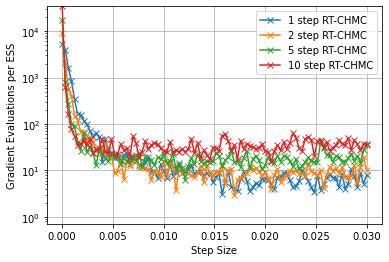

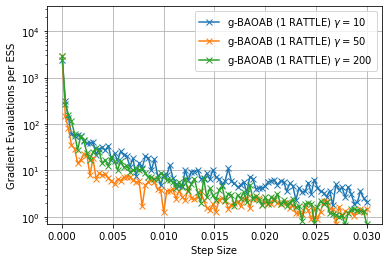

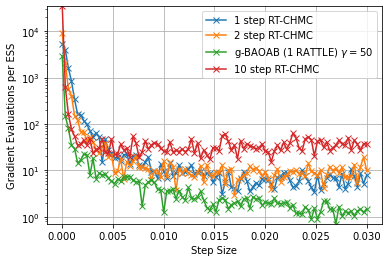

In [23]:
#plt.plot(dt_list,Gradient_p_ESS_DT,'x-',label = '20 step RMHMC')
Num = 100

plt.plot(dt_list[:Num],Gradient_p_ESS_DT_1[:Num], 'x-',label = '1 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_2[:Num], 'x-',label = '2 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_5[:Num], 'x-',label = '5 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_10[:Num], 'x-',label = '10 step CHMC')
plt.ylim([min(Gradient_p_ESS_g_BAOAB_2[:Num]),max(Gradient_p_ESS_RT_10[:Num])])
plt.ylabel('Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('DT-ESS.pdf')
plt.show()



plt.plot(dt_list[:Num],Gradient_p_ESS_RT_1[:Num], 'x-',label = '1 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_2[:Num], 'x-',label = '2 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_5[:Num], 'x-',label = '5 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_10[:Num], 'x-',label = '10 step RT-CHMC')
plt.ylim([min(Gradient_p_ESS_g_BAOAB_2[:Num]),max(Gradient_p_ESS_RT_10[:Num])])
plt.ylabel('Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('RT-ESS.pdf')
plt.show()
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_0_5[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_1)
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_2[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_2)
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_10[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_3)
plt.ylim([min(Gradient_p_ESS_g_BAOAB_2[:Num]),max(Gradient_p_ESS_RT_10[:Num])])
plt.ylabel('Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('g-BAOAB-ESS.pdf')
plt.show()

plt.plot(dt_list[:Num],Gradient_p_ESS_RT_1[:Num], 'x-',label = '1 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_2[:Num], 'x-',label = '2 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_2[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_2)
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_10[:Num], 'x-',label = '10 step RT-CHMC')
plt.ylim([min(Gradient_p_ESS_g_BAOAB_2[:Num]),max(Gradient_p_ESS_RT_10[:Num])])
plt.yscale('log')
plt.ylabel('Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('ESS.pdf')
plt.show()

# Maximum Gradient Evaluation per ESS

In [24]:
import statsmodels.api as sm
#ESS per gradient evaluation

N_samples = 100000

dt_list = np.linspace(0.00001,0.03,100)
print(dt_list)

Gradient_p_ESS_DT_1 = []
Gradient_p_ESS_RT_1 = []

Gradient_p_ESS_DT_2 = []
Gradient_p_ESS_RT_2 = []

Gradient_p_ESS_DT_5 = []
Gradient_p_ESS_RT_5 = []

Gradient_p_ESS_DT_10 = []
Gradient_p_ESS_RT_10 = []

Gradient_p_ESS_g_BAOAB_2 = []
Gradient_p_ESS_g_BAOAB_0_5 = []
Gradient_p_ESS_g_BAOAB_10 = []


accept_RT_list_1 = []
accept_DT_list_1 = []

accept_RT_list_2 = []
accept_DT_list_2 = []

accept_RT_list_5 = []
accept_DT_list_5 = []

accept_RT_list_10 = []
accept_DT_list_10 = []

max_list = np.zeros(dimension)

for dt_ in dt_list:
    
    T = 5*dt_
    
    N_1 = 10.
    N_2 = 50.
    N_3 = 200.
    
    DT_samples_5,accept_DT_5 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_5,accept_RT_5, gradient_evaluations_5 = RRHMC(N_samples,dt_,T,x_init)
    
    g_BAOAB_samples_2 = g_BAOAB_MC(N_2,1,N_samples,dt_,x_init)
    g_BAOAB_samples_0_5 = g_BAOAB_MC(N_1,1,N_samples,dt_,x_init)
    g_BAOAB_samples_10 = g_BAOAB_MC(N_3,1,N_samples,dt_,x_init)
    
    #storing acceptance rates
    accept_RT_list_5.append(accept_RT_5)
    accept_DT_list_5.append(accept_DT_5)
    
    
    T = 1*dt_
    
    DT_samples_1,accept_DT_1 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_1,accept_RT_1, gradient_evaluations_1 = RRHMC(N_samples,dt_,T,x_init)
    
    
    #storing acceptance rates
    accept_RT_list_1.append(accept_RT_1)
    accept_DT_list_1.append(accept_DT_1)
    
    T = 2*dt_
    
    DT_samples_2,accept_DT_2 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_2,accept_RT_2, gradient_evaluations_2 = RRHMC(N_samples,dt_,T,x_init)
    
    #storing acceptance rates
    accept_RT_list_2.append(accept_RT_2)
    accept_DT_list_2.append(accept_DT_2)
    
    
    
    T = 10*dt_
    
    DT_samples_10,accept_DT_10 = RHMC(N_samples,dt_,T,x_init)
    RT_samples_10,accept_RT_10, gradient_evaluations_10 = RRHMC(N_samples,dt_,T,x_init)
    
    
    #storing acceptance rates
    accept_RT_list_10.append(accept_RT_10)
    accept_DT_list_10.append(accept_DT_10)
    #####################################################################
    #Gradient Evaluations per ESS - DT - 1
    front = len(DT_samples_1)//10
    
    N = len(DT_samples_1)- front
    
    for j in range(dimension):

        auto_corr_vector_DT_1 = []

        for i in DT_samples_1:

            auto_corr_vector_DT_1.append(i[j])

        auto_DT_1 = sm.tsa.acf(auto_corr_vector_DT_1[front:],nlags = N//50)

        IAC_DT_1 = np.sum(auto_DT_1)
        
        max_list[j] = IAC_DT_1 
        
    
    IAC_DT_1 = np.max(max_list)
    
    print('Maximum IAC_DT=',2*IAC_DT_1-1)
    
    ESS_percent_DT_1 = 1/(2*IAC_DT_1 - 1)
    
    Gradient_p_ESS_DT_1.append(1./ESS_percent_DT_1)
    
    #Gradient Evaluations per ESS - RT - 1
    front = len(RT_samples_1)//10
    
    N = len(RT_samples_1)- front
    
    for j in range(dimension):

        auto_corr_vector_RT_1 = []

        for i in RT_samples_1:

            auto_corr_vector_RT_1.append(i[j])

        auto_RT_1 = sm.tsa.acf(auto_corr_vector_RT_1[front:],nlags = N//50)

        IAC_RT_1 = np.sum(auto_RT_1)
        
        max_list[j] = IAC_RT_1
        
    IAC_RT_1 = np.max(max_list)
    
    print('IAC_RT=',2*IAC_RT_1-1)
    
    ESS_percent_RT_1 = 1/(2*IAC_RT_1 - 1)
    
    Gradient_p_ESS_RT_1.append(gradient_evaluations_1/ESS_percent_RT_1)
    
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 2
    front = len(DT_samples_2)//10
    
    N = len(DT_samples_2)- front

    for j in range(dimension):
        
        auto_corr_vector_DT_2 = []

        for i in DT_samples_2:

            auto_corr_vector_DT_2.append(i[j])

        auto_DT_2 = sm.tsa.acf(auto_corr_vector_DT_2[front:],nlags = N//50)

        IAC_DT_2 = np.sum(auto_DT_2)
        
        max_list[j] = IAC_DT_2
        
    IAC_DT_2 = np.max(max_list)
    
    print('IAC_DT=',2*IAC_DT_2-1)
    
    ESS_percent_DT_2 = 1/(2*IAC_DT_2 - 1)
    
    Gradient_p_ESS_DT_2.append(2./ESS_percent_DT_2)
    
    #Gradient Evaluations per ESS - RT - 2
    front = len(RT_samples_2)//10
    
    N = len(RT_samples_2)- front
    
    for j in range(dimension):

        auto_corr_vector_RT_2 = []

        for i in RT_samples_2:

            auto_corr_vector_RT_2.append(i[j])

        auto_RT_2 = sm.tsa.acf(auto_corr_vector_RT_2[front:],nlags = N//50)

        IAC_RT_2 = np.sum(auto_RT_2)
        
        max_list[j] = IAC_RT_2
    
    IAC_RT_2 = np.max(max_list)
    
    print('IAC_RT=',2*IAC_RT_2-1)
    
    ESS_percent_RT_2 = 1/(2*IAC_RT_2 - 1)
    
    Gradient_p_ESS_RT_2.append(gradient_evaluations_2/ESS_percent_RT_2)
    
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 5
    front = len(DT_samples_5)//10
    
    N = len(DT_samples_5)- front
    
    for j in range(dimension):

        auto_corr_vector_DT_5 = []

        for i in DT_samples_5:

            auto_corr_vector_DT_5.append(i[j])

        auto_DT_5 = sm.tsa.acf(auto_corr_vector_DT_5[front:],nlags = N//50)

        IAC_DT_5 = np.sum(auto_DT_5)
        
        max_list[j] = IAC_DT_5
        
    IAC_DT_5 = np.max(max_list)
    
    print('IAC_DT=',2*IAC_DT_5-1)
    
    ESS_percent_DT_5 = 1/(2*IAC_DT_5 - 1)
    
    Gradient_p_ESS_DT_5.append(5./ESS_percent_DT_5)
    
    #Gradient Evaluations per ESS - RT - 5
    front = len(RT_samples_5)//10
    
    N = len(RT_samples_5)- front
    
    for j in range(dimension):

        auto_corr_vector_RT_5 = []

        for i in RT_samples_5:

            auto_corr_vector_RT_5.append(i[j])

        auto_RT_5 = sm.tsa.acf(auto_corr_vector_RT_5[front:],nlags = N//50)

        IAC_RT_5 = np.sum(auto_RT_5)
        
        max_list[j] = IAC_RT_5
        
    IAC_RT_5 = np.max(max_list)

    print('IAC_RT=',2*IAC_RT_5-1)
    
    ESS_percent_RT_5 = 1/(2*IAC_RT_5 - 1)
    
    Gradient_p_ESS_RT_5.append(gradient_evaluations_5/ESS_percent_RT_5)
    
    
    
    #####################################################################
    #Gradient Evaluations per ESS - DT - 10
    front = len(DT_samples_10)//10
    
    N = len(DT_samples_10)- front
    
    for j in range(dimension):

        auto_corr_vector_DT_10 = []

        for i in DT_samples_10:

            auto_corr_vector_DT_10.append(i[j])

        auto_DT_10 = sm.tsa.acf(auto_corr_vector_DT_10[front:],nlags = N//50)

        IAC_DT_10 = np.sum(auto_DT_10)
        
        max_list[j] = IAC_DT_10
        
    IAC_DT_10 = np.max(max_list)
    
    print('IAC_DT=',2*IAC_DT_10-1)
    
    ESS_percent_DT_10 = 1/(2*IAC_DT_10 - 1)
    
    Gradient_p_ESS_DT_10.append(10./ESS_percent_DT_10)
    
    #Gradient Evaluations per ESS - RT - 10
    front = len(RT_samples_10)//10
    
    N = len(RT_samples_10)- front
    
    for j in range(dimension):

        auto_corr_vector_RT_10 = []

        for i in RT_samples_10:

            auto_corr_vector_RT_10.append(i[j])

        auto_RT_10 = sm.tsa.acf(auto_corr_vector_RT_10[front:],nlags = N//50)

        IAC_RT_10 = np.sum(auto_RT_10)
        
        max_list[j] = IAC_RT_10
        
        
    IAC_RT_10 = np.max(max_list)
    
    print('IAC_RT=',2*IAC_RT_10-1)
    
    ESS_percent_RT_10 = 1/(2*IAC_RT_10 - 1)
    
    Gradient_p_ESS_RT_10.append(gradient_evaluations_10/ESS_percent_RT_10)
    
    
    
    ###################################################################
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 2
    front = len(g_BAOAB_samples_2)//10
    
    N = len(g_BAOAB_samples_2)- front
    
    for j in range(dimension):

        auto_corr_vector_g_BAOAB_2 = []

        for i in g_BAOAB_samples_2:

            auto_corr_vector_g_BAOAB_2.append(i[j])

        auto_g_BAOAB_2 = sm.tsa.acf(auto_corr_vector_g_BAOAB_2[front:],nlags = N//50)

        IAC_g_BAOAB_2 = np.sum(auto_g_BAOAB_2)
        
        max_list[j] = IAC_g_BAOAB_2 
        
    IAC_g_BAOAB_2 = np.max(max_list)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_2-1)
    
    ESS_percent_g_BAOAB_2 = 1/(2*IAC_g_BAOAB_2 - 1)
    
    Gradient_p_ESS_g_BAOAB_2.append(1/ESS_percent_g_BAOAB_2)
    
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 0.5
    front = len(g_BAOAB_samples_0_5)//10
    
    N = len(g_BAOAB_samples_0_5)- front
    
    for j in range(dimension):

        auto_corr_vector_g_BAOAB_0_5 = []

        for i in g_BAOAB_samples_0_5:

            auto_corr_vector_g_BAOAB_0_5.append(i[j])

        auto_g_BAOAB_0_5 = sm.tsa.acf(auto_corr_vector_g_BAOAB_0_5[front:],nlags = N//50)

        IAC_g_BAOAB_0_5 = np.sum(auto_g_BAOAB_0_5)
        
        max_list[j] = IAC_g_BAOAB_0_5
        
    IAC_g_BAOAB_0_5 = np.max(max_list)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_0_5-1)
    
    ESS_percent_g_BAOAB_0_5 = 1/(2*IAC_g_BAOAB_0_5 - 1)
    
    Gradient_p_ESS_g_BAOAB_0_5.append(1/ESS_percent_g_BAOAB_0_5)
    
    
    #Gradient Evaluations per ESS - g-BAOAB - γ = 10.0
    front = len(g_BAOAB_samples_10)//10
    
    N = len(g_BAOAB_samples_10)- front
    
    for j in range(dimension):

        auto_corr_vector_g_BAOAB_10 = []

        for i in g_BAOAB_samples_10:

            auto_corr_vector_g_BAOAB_10.append(i[j])

        auto_g_BAOAB_10 = sm.tsa.acf(auto_corr_vector_g_BAOAB_10[front:],nlags = N//50)

        IAC_g_BAOAB_10 = np.sum(auto_g_BAOAB_10)
        
        max_list[j] = IAC_g_BAOAB_10 
        
    IAC_g_BAOAB_10 = np.max(max_list)
    
    print('IAC_g_BAOAB=',2*IAC_g_BAOAB_10-1)
    
    ESS_percent_g_BAOAB_10 = 1/(2*IAC_g_BAOAB_10 - 1)
    
    Gradient_p_ESS_g_BAOAB_10.append(1/ESS_percent_g_BAOAB_10)


    

[1.00000000e-05 3.12929293e-04 6.15858586e-04 9.18787879e-04
 1.22171717e-03 1.52464646e-03 1.82757576e-03 2.13050505e-03
 2.43343434e-03 2.73636364e-03 3.03929293e-03 3.34222222e-03
 3.64515152e-03 3.94808081e-03 4.25101010e-03 4.55393939e-03
 4.85686869e-03 5.15979798e-03 5.46272727e-03 5.76565657e-03
 6.06858586e-03 6.37151515e-03 6.67444444e-03 6.97737374e-03
 7.28030303e-03 7.58323232e-03 7.88616162e-03 8.18909091e-03
 8.49202020e-03 8.79494949e-03 9.09787879e-03 9.40080808e-03
 9.70373737e-03 1.00066667e-02 1.03095960e-02 1.06125253e-02
 1.09154545e-02 1.12183838e-02 1.15213131e-02 1.18242424e-02
 1.21271717e-02 1.24301010e-02 1.27330303e-02 1.30359596e-02
 1.33388889e-02 1.36418182e-02 1.39447475e-02 1.42476768e-02
 1.45506061e-02 1.48535354e-02 1.51564646e-02 1.54593939e-02
 1.57623232e-02 1.60652525e-02 1.63681818e-02 1.66711111e-02
 1.69740404e-02 1.72769697e-02 1.75798990e-02 1.78828283e-02
 1.81857576e-02 1.84886869e-02 1.87916162e-02 1.90945455e-02
 1.93974747e-02 1.970040

50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 338.94171293974796
IAC_RT= 272.28629950724763
IAC_DT= 95.94762377901483
IAC_RT= 69.49313363763217
IAC_DT= 12.708639690708548
IAC_RT= 7.766966353658535
IAC_DT= 3.9781482964349273
IAC_RT= 3.7767165832156095
IAC_g_BAOAB= 30.687447511700277
IAC_g_BAOAB= 24.17435441898007
IAC_g_BAOAB= 98.865062873811
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
700

10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 58.02936321762171
IAC_RT= 36.43827759950226
IAC_DT= 14.578937055588142
IAC_RT= 9.2179203978585
IAC_DT= 3.2806179170835064
IAC_RT= 2.441472852911214
IAC_DT= 40.88980655022924
IAC_RT= 2.5595534431019846
IAC_g_BAOAB= 11.215666059083297
IAC_g_BAOAB= 7.902921830753343
IAC_g_BAOAB= 29.960387004928005
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
3000

IAC_g_BAOAB= 20.915406079348298
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 18.332278805254457
IAC_RT= 16.89006134957487
IAC_DT= 8.894722022144682
IAC_RT= 7.363463072733023
IAC_DT= 0.9555936103980713
IAC_RT= 1.3545542777913449
IAC_DT= 11.123777059809848
IAC_RT= 1.6894311173445136
IAC_g_BAOAB= 6.130630527286481
IAC_g_BAOAB= 8.482798803153013
IAC_g_BAOAB= 18.706615303062513
0
10000
20000
30000
40000
50000
60000

IAC_DT= 155.8942186851709
IAC_RT= 3.028396849317904
IAC_g_BAOAB= 3.775701601448554
IAC_g_BAOAB= 6.4941801479878
IAC_g_BAOAB= 16.61106913755084
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 22.22123461221561
IAC_RT= 7.455812323955628
IAC_DT= 3.097911431739612
IAC_RT= 3.300136734236978
IAC_DT= 8.617037758503091
IAC_RT= 2.118773700589356
IAC_DT= 34.235889108705535
IAC_RT= 2.5524771392560694
IAC_g_BAOAB= 5.86477092

IAC_RT= 7.664672729333036
IAC_DT= 2.0952434168438963
IAC_RT= 2.3653601756416283
IAC_DT= 10.957481626010455
IAC_RT= 3.100792335309542
IAC_DT= 12.469195261154455
IAC_RT= 2.705997684320342
IAC_g_BAOAB= 7.037741049792501
IAC_g_BAOAB= 4.338816056600526
IAC_g_BAOAB= 9.82036193869668
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 14.732562843167191
IAC_RT= 9.92416096316602
IAC_DT= 2.452043167014128
IAC_RT= 2.9702161436

10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 5.405883398252464
IAC_RT= 5.808458845530507
IAC_DT= 1.8072451096303217
IAC_RT= 2.6585510164340964
IAC_DT= 8.013217032108635
IAC_RT= 2.273147257111439
IAC_DT= 6.36773811134686
IAC_RT= 1.3921546705145347
IAC_g_BAOAB= 2.6850536132183422
IAC_g_BAOAB= 3.113309043748223
IAC_g_BAOAB= 10.865686896072312
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
300

40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 10.571957140027452
IAC_RT= 3.888188311151519
IAC_DT= 0.8574287850437026
IAC_RT= 1.8747266384303112
IAC_DT= 63.51476351541315
IAC_RT= 2.3762565305036127
IAC_DT= 30.397847700245734
IAC_RT= 1.5725374274998432
IAC_g_BAOAB= 2.365908882717504
IAC_g_BAOAB= 3.742081564878541
IAC_g_BAOAB= 5.180612766028066
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
6

50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 4.834308028215688
IAC_RT= 3.1328152892530268
IAC_DT= 3.6365059327107296
IAC_RT= 2.433065216543023
IAC_DT= 1.8061789523560163
IAC_RT= 2.468703481695389
IAC_DT= 6.764140447093865
IAC_RT= 2.043183744119192
IAC_g_BAOAB= 1.19909350185472
IAC_g_BAOAB= 2.5874179350115973
IAC_g_BAOAB= 3.807699108847836
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
7000

40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 3.2484109399731844
IAC_RT= 3.3298755006878116
IAC_DT= 2.36380560283642
IAC_RT= 2.7554859754797585
IAC_DT= 11.982820282140148
IAC_RT= 2.1189564699303403
IAC_DT= 1.7582978148388206
IAC_RT= 2.5505813345066515
IAC_g_BAOAB= 1.5994295239198166
IAC_g_BAOAB= 2.620004143932556
IAC_g_BAOAB= 3.8601253649734053
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000

IAC_DT= 138.32596121370477
IAC_RT= 3.341952769245583
IAC_g_BAOAB= 1.622379958840753
IAC_g_BAOAB= 1.5504629014264184
IAC_g_BAOAB= 2.084829820087009
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 2.844032164331663
IAC_RT= 3.0278443340821886
IAC_DT= 3.331530980493276
IAC_RT= 1.9463300596287478
IAC_DT= 2556.6845471411543
IAC_RT= 2.2206139247047028
IAC_DT= 1985.2974693047215
IAC_RT= 1.9036463248644182
IAC_g_BAOAB= 1.

Maximum IAC_DT= 2.2877244134662122
IAC_RT= 2.8422606922006475
IAC_DT= 8.606278406609045
IAC_RT= 1.9029512684891707
IAC_DT= 9.134390229644517
IAC_RT= 4.458153649291093
IAC_DT= 4.146468092492424
IAC_RT= 4.10424147164356
IAC_g_BAOAB= 2.0449956728872754
IAC_g_BAOAB= 1.8649625074963607
IAC_g_BAOAB= 2.3816067636956095
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Maximum IAC_DT= 2.6091954587752455
IAC_RT= 3.0405668580503384
IAC_DT= 

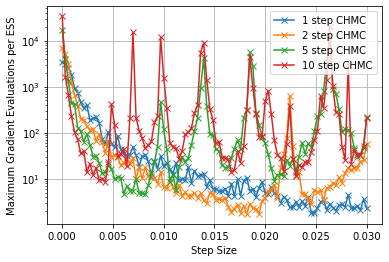

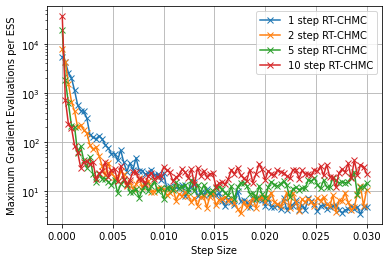

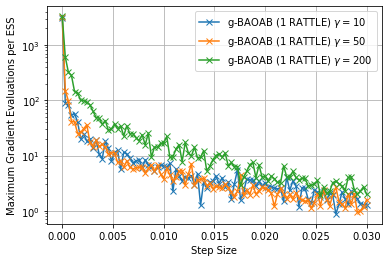

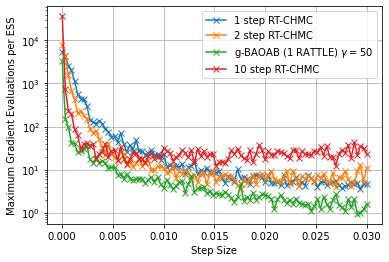

In [25]:
#plt.plot(dt_list,Gradient_p_ESS_DT,'x-',label = '20 step RMHMC')
Num = 100

plt.plot(dt_list[:Num],Gradient_p_ESS_DT_1[:Num], 'x-',label = '1 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_2[:Num], 'x-',label = '2 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_5[:Num], 'x-',label = '5 step CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_DT_10[:Num], 'x-',label = '10 step CHMC')
plt.ylabel('Maximum Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('Max-DT-ESS.pdf')
plt.show()



plt.plot(dt_list[:Num],Gradient_p_ESS_RT_1[:Num], 'x-',label = '1 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_2[:Num], 'x-',label = '2 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_5[:Num], 'x-',label = '5 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_10[:Num], 'x-',label = '10 step RT-CHMC')
plt.ylabel('Maximum Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('Max-RT-ESS.pdf')
plt.show()
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_0_5[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_1)
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_2[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_2)
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_10[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_3)
plt.ylabel('Maximum Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('Max-g-BAOAB-ESS.pdf')
plt.show()

plt.plot(dt_list[:Num],Gradient_p_ESS_RT_1[:Num], 'x-',label = '1 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_2[:Num], 'x-',label = '2 step RT-CHMC')
plt.plot(dt_list[:Num],Gradient_p_ESS_g_BAOAB_2[:Num],'x-', label = 'g-BAOAB (1 RATTLE) $\gamma = $%i' %N_2)
plt.plot(dt_list[:Num],Gradient_p_ESS_RT_10[:Num], 'x-',label = '10 step RT-CHMC')




plt.ylabel('Maximum Gradient Evaluations per ESS')
plt.xlabel('Step Size')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('Max-ESS.pdf')
plt.show()